Processing maw_VV_Pup_r_240s_2025-02-21T06-04-05.fts
[(array(2585.57981067), array(1788.07966545)), (array(2411.9073399), array(1163.20325183)), (array(2658.85143549), array(1444.15036167)), (array(2842.8581241), array(1291.22541883)), (array(2992.45947804), array(1901.04064308)), (2387.7018264910707, 1650.0086615655007)]
Processing maw_VV_Pup_r_240s_2025-02-21T05-35-10.fts
[(array(2573.74287297), array(1801.02945431)), (array(2400.11210825), array(1176.09545929)), (array(2647.0350379), array(1457.07547701)), (array(2831.05600765), array(1304.15355941)), (array(2980.62047282), array(1914.03495127)), (2375.8735839719134, 1662.9282058188014)]


Processing maw_VV_Pup_r_240s_2025-02-21T06-34-05.fts
[(array(2590.06770653), array(1778.86885911)), (array(2416.43231803), array(1154.16911981)), (array(2663.34551387), array(1435.0075867)), (array(2847.34931202), array(1282.08991462)), (array(2996.90679788), array(1891.7397702)), (2392.2131677698017, 1640.8616980921902)]


Processing maw_VV_Pup_r_240s_2025-02-21T06-19-05.fts
[(array(2587.69589802), array(1782.87205579)), (array(2414.19996794), array(1158.07999915)), (array(2661.02673159), array(1438.9883267)), (array(2845.05881567), array(1286.03490001)), (array(2994.51958676), array(1895.65951242)), (2389.853453544418, 1644.887539752263)]


0.03512457487542411 0.05187907163087383


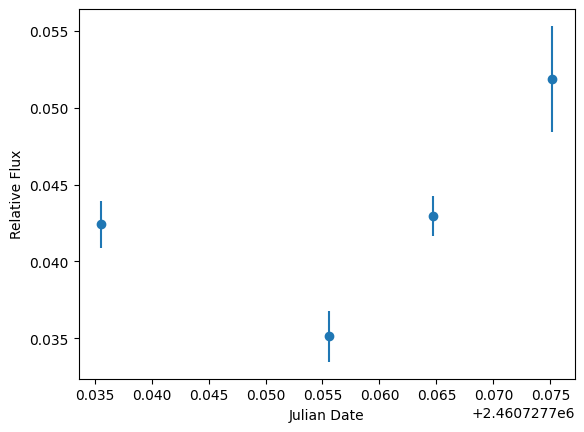

/var/folders/l3/kynmmffn6mb9tjg_c1n4qtd80000gn/T/ipykernel_1792/1032039296.py:182: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  x_dat = pd.read_csv('/Users/nathaliehaurberg/Data/MagneticCVs/VVPup_Xband_Feb22.dat', delim_whitespace=True, header=None)


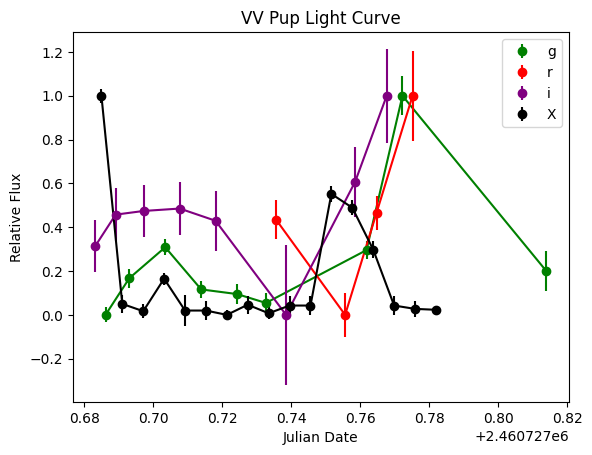

In [3]:
from astropy.stats import sigma_clipped_stats
from astropy.io import fits
from photutils.aperture import ApertureStats, CircularAperture, CircularAnnulus, aperture_photometry
import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import SigmaClip
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
import pandas as pd
import os
import glob
from astropy.time import Time


def make_light_curve(file_dir):
    # Change to the directory containing the images
    os.chdir(file_dir + '/' + filter + '/')

    # Find all FITS files in the directory
    image_files = glob.glob('*.fts')

    # Define the list of star coordinates 
    star_list = [(2524.1591, 1855.3702), (2350.4573, 1230.4712), (2597.4297, 1511.4885), (2781.4578, 1358.5997),(2931.032, 1968.4543)]

    vv_pup = SkyCoord.from_name('VV Pup')
    ra = vv_pup.ra.deg
    dec = vv_pup.dec.deg

    data = fits.getdata('/Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_RLMT_Feb_2025/g/maw_VV_Pup_g_240s_2025-02-21T04-21-00.fts')
    header = fits.getheader('/Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_RLMT_Feb_2025/g/maw_VV_Pup_g_240s_2025-02-21T04-21-00.fts')

    rdnoise = 6.7
    egain = header['EGAIN']
    gain = 4*egain
        
    wcs = WCS(header)
    star_list_ra_dec = []
    for x, y in star_list:
        star_ra, star_dec = wcs.all_pix2world(x, y, 0)
        star_list_ra_dec = star_list_ra_dec + [(star_ra, star_dec)]

    # Define the aperture and annulus parameters
    aperture_radius = 8  # Radius of the aperture
    annulus_inner_radius = 22  # Inner radius of the annulus
    annulus_outer_radius = 30  # Outer radius of the annulus

    # Initialize a list to store results for all files
    all_results = []

    # Loop over each image file
    for image_file in image_files:
        # Load the FITS data
        data = fits.getdata(image_file)
        header = fits.getheader(image_file)
        print('Processing', image_file)

        wcs = WCS(header)
        xst, yst = wcs.all_world2pix(ra, dec,0)
        star_list = []
        for x, y in star_list_ra_dec:
            x_star, y_star = wcs.all_world2pix(x, y,0)
            star_list = star_list + [(x_star, y_star)]
        xst = float(xst)
        yst = float(yst)
        star_list = star_list + [(xst, yst)]
        print(star_list)

        exptime = header['EXPTIME']
        exptimedays = exptime/(24*3600)
        addjd = exptimedays/2
        
        # Calculate the mean, median, and standard deviation of the data
        mean, median, std = sigma_clipped_stats(data, sigma=3.0)
        
        sigclip = SigmaClip(sigma=3., maxiters=10)

        # Get the Julian Date
        jd = header['JD']
        
        file_results = {'file': image_file, 'Julian_Date': (jd+addjd)}
        
        # Perform aperture photometry for each star
        for i, (x, y) in enumerate(star_list):
            ap = CircularAperture((x, y), r=aperture_radius)
            an = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
            bkg_stats = ApertureStats(data, an, sigma_clip=sigclip)
            ap_stats = ApertureStats(data, ap, local_bkg=bkg_stats.median)
        
            x, y = ap_stats.centroid
            #print(x, y)
        
            aperture = CircularAperture((x, y), r=aperture_radius)
            annulus_aperture = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
            
            # Perform aperture photometry
            phot_table = aperture_photometry(data, aperture)
            bkgstats = ApertureStats(data, annulus_aperture, sigma_clip=sigclip)
            
            # Calculate the background in the annulus
            bkg_mean = bkgstats.mean
            bkg_sum = bkg_mean * aperture.area
            
            bkg_mean_nopedestal = bkg_mean-1000
            bkg_sum_nopedestal = bkg_mean_nopedestal * aperture.area

            
            # Subtract the background from the aperture photometry
            source_sum = phot_table['aperture_sum'][0]*gain - bkg_sum*gain

            # Error calculation (Poisson noise + background noise)
            error = np.sqrt((phot_table['aperture_sum'][0]-1000*aperture.area)*gain + (aperture.area/annulus_aperture.area)**2*bkg_sum_nopedestal*gain + aperture.area*rdnoise**2)
            #error = np.sqrt((phot_table['aperture_sum'][0]-1000*aperture.area) + ((aperture.area)**2/annulus_aperture.area)*bkg_sum_nopedestal + (aperture.area)*rdnoise**2)

            # Turn into a magnitude
            source_mag = -2.5 * np.log10(source_sum / exptime)
            source_mag_err = 1.0857 * error / source_sum

            # Store the results with dynamic column names
            file_results[f'star_{i}_x'] = x
            file_results[f'star_{i}_y'] = y
            file_results[f'star_{i}_flux'] = source_sum
            file_results[f'star_{i}_error'] = error
            file_results[f'star_{i}_background'] = bkg_sum

        # Append the results for this file to the list of all results
        all_results.append(file_results)

    # Convert the results to a DataFrame for easy analysis
    results_df = pd.DataFrame(all_results)

    # Optionally, display the image with the apertures and annuli
    '''for image_file in image_files:
        data = fits.getdata(image_file)
        header = fits.getheader(image_file)
        wcs = WCS(header)

        plt.imshow(data, vmin=median-3*std, vmax=median+3*std, cmap='viridis')
        for (x, y) in star_list:
            aperture = CircularAperture((x, y), r=aperture_radius)
            annulus_aperture = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
            aperture.plot(color='blue', lw=1.5)
            annulus_aperture.plot(color='red', lw=1.5)
        plt.show()'''

    # take the result from the dataframe of star_0_flux and star_1_flux and add together
    results_df['total_flux'] = results_df['star_0_flux'] + results_df['star_1_flux'] + results_df['star_2_flux'] + results_df['star_3_flux'] + results_df['star_4_flux']
    results_df['rel_flux']=results_df['star_5_flux']/results_df['total_flux']

    for i in range(5):
        results_df[f'star_{i}_relflux'] = results_df[f'star_{i}_flux']/results_df['total_flux']

    total_flux_err = np.sqrt(results_df['star_0_error']**2 + results_df['star_1_error']**2 + results_df['star_2_error']**2 + results_df['star_3_error']**2 + results_df['star_4_error']**2)

    #calculate the error on the relative flux
    results_df['star_5_relerror'] = (results_df['star_5_flux']/results_df['total_flux'])*(np.sqrt((results_df['star_5_error']/results_df['star_5_flux'])**2 + (total_flux_err/results_df['total_flux'])**2))

    min_flux = np.min(results_df['rel_flux'])
    max_flux = np.max(results_df['rel_flux'])
    print(min_flux, max_flux)
    # Normalize the relative flux
    results_df['norm_rel_flux'] = (results_df['rel_flux']-min_flux)/(max_flux-min_flux)
    results_df['norm_rel_flux_error'] = results_df['star_5_relerror']/(np.max(results_df['rel_flux'])-np.min(results_df['rel_flux']))
    # Save the results to a CSV file
    results_df.to_csv('/Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_RLMT_Feb_2025/Results_norm_' + filter + '.csv', index=False)

    #Plot the relative flux
    #plt.plot(results_df['Julian_Date'], results_df['rel_flux'], 'o')
    plt.errorbar(results_df['Julian_Date'], results_df['rel_flux'], yerr=results_df['star_5_relerror'], fmt='o')
    plt.xlabel('Julian Date')
    plt.ylabel('Relative Flux')
    plt.show()

file_dir = '/Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_RLMT_Feb_2025/'
filter = 'r'



make_light_curve(file_dir)

#read in the X-band data'
x_dat = pd.read_csv('/Users/nathaliehaurberg/Data/MagneticCVs/VVPup_Xband_Feb22.dat', delim_whitespace=True, header=None)  
time = x_dat.iloc[:,0].astype(str)
flux = x_dat.iloc[:,1]
flux_err = x_dat.iloc[:,2]
min_flux = np.min(flux)
max_flux = np.max(flux)
norm_x_flux = (flux-min_flux)/(max_flux-min_flux)
norm_x_flux_err = flux_err/(np.max(flux)-np.min(flux))

# Convert time to ISO format and then to Julian Date
time_iso = '2025-02-21T' + time  # Vectorized string concatenation
time_iso_list = time_iso.tolist() 
t = Time(time_iso_list, format='isot', scale='utc') # Convert all at once
jd = t.jd
xmag = -2.5*np.log10(flux*10**(-6)/3631)-3
xmag_err = 1.0857 * flux_err / flux

# Create a DataFrame from the original dictionary

x_results = pd.DataFrame({
    'Julian_Date': jd,
    'x_flux': flux,
    'x_flux_err': flux_err,
    'norm_x_flux': norm_x_flux,
    'norm_x_flux_err': norm_x_flux_err,
    'x_mag': xmag,
    'x_mag_err': xmag_err,
})

lc_g = pd.read_csv('/Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_RLMT_Feb_2025/Results_norm_g.csv')
lc_r = pd.read_csv('/Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_RLMT_Feb_2025/Results_norm_r.csv')
lc_i = pd.read_csv('/Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_RLMT_Feb_2025/Results_norm_i.csv')


#sort the dataframes by Julian Date
lc_g = lc_g.sort_values(by=['Julian_Date'])
lc_r = lc_r.sort_values(by=['Julian_Date'])
lc_i = lc_i.sort_values(by=['Julian_Date'])
x_results = x_results.sort_values(by=['Julian_Date'])


plt.errorbar(lc_g['Julian_Date'], lc_g['norm_rel_flux'], yerr=lc_g['norm_rel_flux_error'], fmt='o', label='g', color='green')
plt.plot(lc_g['Julian_Date'], lc_g['norm_rel_flux'], color='green')    
plt.errorbar(lc_r['Julian_Date'], lc_r['norm_rel_flux'], yerr=lc_r['norm_rel_flux_error'], fmt='o', label='r', color='red')
plt.plot(lc_r['Julian_Date'], lc_r['norm_rel_flux'], color='red')
plt.errorbar(lc_i['Julian_Date'], lc_i['norm_rel_flux'], yerr=lc_i['norm_rel_flux_error'], fmt='o', label='i', color='purple')
plt.plot(lc_i['Julian_Date'], lc_i['norm_rel_flux'], color='purple')
plt.errorbar(x_results['Julian_Date'], x_results['norm_x_flux'], yerr=x_results['norm_x_flux_err'], fmt='o', label='X', color='black')
plt.plot(x_results['Julian_Date'], x_results['norm_x_flux'], color='black')

'''plt.scatter(lc_g['Julian_Date'], lc_g['star_0_relflux']/np.mean(lc_g['star_0_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_g['Julian_Date'], lc_g['star_1_relflux']/np.mean(lc_g['star_1_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_g['Julian_Date'], lc_g['star_2_relflux']/np.mean(lc_g['star_2_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_g['Julian_Date'], lc_g['star_3_relflux']/np.mean(lc_g['star_3_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_g['Julian_Date'], lc_g['star_4_relflux']/np.mean(lc_g['star_4_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_i['Julian_Date'], lc_i['star_0_relflux']/np.mean(lc_i['star_0_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_i['Julian_Date'], lc_i['star_1_relflux']/np.mean(lc_i['star_1_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_i['Julian_Date'], lc_i['star_2_relflux']/np.mean(lc_i['star_2_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_i['Julian_Date'], lc_i['star_3_relflux']/np.mean(lc_i['star_3_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_i['Julian_Date'], lc_i['star_4_relflux']/np.mean(lc_i['star_4_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_r['Julian_Date'], lc_r['star_0_relflux']/np.mean(lc_r['star_0_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_r['Julian_Date'], lc_r['star_1_relflux']/np.mean(lc_r['star_1_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_r['Julian_Date'], lc_r['star_2_relflux']/np.mean(lc_r['star_2_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_r['Julian_Date'], lc_r['star_3_relflux']/np.mean(lc_r['star_3_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_r['Julian_Date'], lc_r['star_4_relflux']/np.mean(lc_r['star_4_relflux']), alpha=0.5, color='gray')'''



plt.title('VV Pup Light Curve')
plt.xlabel('Julian Date')
plt.ylabel('Relative Flux')
plt.legend()
plt.show()

In [4]:
import numpy as np

# Example time-varying data
time_series = np.array([10, 15, 20, 30, 25, 40, 50, 45])

# Apply min-max normalization
normalized_data = (time_series - np.min(time_series)) / (np.max(time_series) - np.min(time_series))

print(normalized_data)


[0.    0.125 0.25  0.5   0.375 0.75  1.    0.875]
